In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
#from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer, Vars, reset, trackerreset, datareset
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
#from lowEBMs.Packages.Variables import 
#from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs.Packages.Optimization import coremodule
import lowEBMs.Packages.Constants as const
from lowEBMs import update_plotstyle, moving_average
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)

In [3]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)
#Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
#np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
Year_volc_1800_1850=Year_volc[int(1000*365/4):int(1040*365/4)]
Year_volc_1808_1858=Year_volc[int(1008*365/4):int(1048*365/4)]
EVA_GMT_1800_1850=EVA_GMT[int(1000*365/4):int(1040*365/4)]
EVA_GMT_1808_1858=EVA_GMT[int(1008*365/4):int(1048*365/4)]
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')

In [7]:
def coremodule(config,P0,P_pert_ratio,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            P_pert=(Pmax-Pmin)*P_pert_ratio
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert_ratio

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [ ]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b']]
#labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func3','f'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([70*4.2e6,230,2.5])
#P0=np.array([50*4.2e6,0.5,1.9e-15,0,1.165,1.165,1.165])
#Pmin=np.array([0.5*10*4.2e6,0.4,0.6e-15,-50,0.9,0.9,0.9])
#Pmax=np.array([100*4.2e6,0.6,5e-15,50,1.2,1.2,1.2])
#P_pert_ralative=[1/10000,1/10000,1/10000,1/10000,1/10000,1/10000]
labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
P0=np.zeros(18)
Pmax=np.full(18,50)
Pmin=np.full(18,-50)
#print(Pmax)
P_pert_ratio=1/10000
#Pmin=np.array([20*4.2e6,190,1.7])
#Pmax=np.array([120*4.2e6,250,3.3])
#P_pert=(Pmax-Pmin)/100
precision=1e-6
maxlength=int(100)
targetmode='Coupled'
target={'GMT':EVA_GMT_1808_1858,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.33
num_params=18
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini')
#print(config_CTRL)
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Sellers_Offset.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[5091.30025057 5090.96696618 5091.60203888 5090.32411016 5092.25327875
 5089.63895442 5093.03159183 5089.02812291 5093.69434753 5088.57179181
 5094.20892289 5088.29330253 5094.52477879 5088.14834063 5094.68433353
 5088.06511028 5094.77233089 5088.00176901 5094.84118861 5088.0158072
 5094.8248961  5088.11123304 5094.72009535 5088.25944488 5094.55758372
 5088.33628808 5094.46304336 5088.51185166 5094.27783302 5088.92084215
 5093.8145484  5089.49362249 5093.17225775 5090.15452056 5092.4336405
 5090.89802922 5091.6676638 ]
1e-08
[0.00635073 0.01929169 0.03392637 0.04666225 0.05637131 0.06231476
 0.06535993 0.06707221 0.0683942  0.06809089 0.06608862 0.06298139
 0.06126755 0.05765981 0.04893706 0.03678635 0.0227912  0.00769635]
Iteration no.1


[4939.13764877 4938.98850145 4939.28395466 4938.69830519 4939.56917251
 4938.3879161  4939.88751104 4938.11407215 4940.15651291 4937.91603195
 4940.371967   4937.79120592 4940.49322795 4937.74628833 4940.55371667
 4937.6954831  4940.60127136 4937.66599703 4940.6339676  4937.66772862
 4940.62947248 4937.71511182 4940.58498789 4937.76283714 4940.52170396
 4937.79935254 4940.48606543 4937.87453979 4940.41261005 4938.05961243
 4940.22047786 4938.31177164 4939.95496328 4938.61559221 4939.65099911
 4938.95211024 4939.31251322]
1.7739564230413957e-08
[0.01159194 0.03474049 0.06052853 0.08289426 0.09993853 0.11024746
 0.11516248 0.11861962 0.1210447  0.12063093 0.11699897 0.11192248
 0.10892867 0.10268407 0.08726987 0.06593586 0.04115887 0.01408974]
Iteration no.2


[4893.47534371 4893.40408376 4893.54660464 4893.2654088  4893.68528555
 4893.1119946  4893.83871192 4892.98023292 4893.86440869 4892.87910807
 4893.83346439 4892.8198039  4893.79988853 4892.79327055 4893.77849827
 4892.76218576 4893.78755879 4892.74333481 4893.79020382 4892.74400524
 4893.79145596 4892.76483631 4893.80403106 4892.7937877  4893.82397304
 4892.80799739 4893.83661523 4892.84566541 4893.8525744  4892.94152756
 4893.87730571 4893.07116941 4893.87381555 4893.22147966 4893.72921612
 4893.38732443 4893.56336396]
2.857249945308397e-08
[0.01566412 0.04673742 0.08129267 0.10815737 0.12720687 0.13825092
 0.1433129  0.14791709 0.15095636 0.15055922 0.14669137 0.14135745
 0.13831885 0.13145398 0.11400739 0.08886946 0.05566617 0.01911963]
Iteration no.3


[4868.73073215 4868.65972114 4868.80174395 4868.52155014 4868.93992064
 4868.36870999 4869.09277326 4868.2374553  4869.22404464 4868.13674934
 4869.32476851 4868.07773047 4869.38380172 4868.05134408 4869.41019611
 4868.02040366 4869.44114485 4868.00163511 4869.45991835 4868.0023052
 4869.45924823 4868.02305089 4869.4384974  4868.05186484 4869.40967555
 4868.06596267 4869.3955716  4868.10338814 4869.35813338 4868.19884448
 4869.26265871 4868.32799566 4869.1334903  4868.47776248 4868.98371029
 4868.6430191  4868.8184462 ]
8.589630252453263e-08
[0.02786335 0.0826739  0.14348702 0.19290174 0.22925333 0.25043761
 0.26003327 0.26995351 0.2762175  0.27570524 0.26827299 0.25798837
 0.25252734 0.23923196 0.2053851  0.15805847 0.09912521 0.03418817]
Iteration no.4


[4774.1953348  4774.12531462 4774.26535573 4773.98914622 4774.40153007
 4773.83858631 4774.55210292 4773.70934473 4774.68136186 4773.61029777
 4774.78042745 4773.55240236 4774.83833769 4773.52659194 4774.86415634
 4773.49622008 4774.89453676 4773.47777674 4774.9129852  4773.47844512
 4774.9123168  4773.49885285 4774.89190374 4773.52712591 4774.86362257
 4773.54078916 4774.84995315 4773.57726811 4774.81346124 4773.67111884
 4774.71959146 4773.79832    4774.59237227 4773.94592425 4774.44475421
 4774.10884074 4774.28182991]
5.579748623586915e-06
[0.80925753 2.38367209 4.12473033 5.61651295 6.7582828  7.42563349
 7.72330639 8.07220907 8.28431993 8.27634877 8.04114679 7.71530378
 7.5573333  7.13687889 6.05559881 4.58867057 2.88247098 0.99942423]
Iteration no.5


[1028.25931667 1028.25776577 1028.26086795 1028.25464783 1028.2639879
 1028.25066161 1028.26797658 1028.24688103 1028.27175972 1028.24380847
 1028.27483404 1028.24193282 1028.27671011 1028.24042507 1028.27821865
 1028.23926392 1028.27938074 1028.23861182 1028.28003341 1028.2385844
 1028.28006077 1028.23920978 1028.27943472 1028.24033678 1028.27830674
 1028.24185171 1028.27679211 1028.24358367 1028.27505972 1028.24712134
 1028.27151955 1028.25116025 1028.26747779 1028.25479996 1028.26383537
 1028.25792692 1028.26070667]
5.735035312753592e-06
[0.82704869 2.4372377  4.22403232 5.75919312 6.93621556 7.62508244
 7.94005391 8.30228048 8.52187418 8.5142172  8.27183823 7.93306283
 7.75771775 7.31739511 6.19552341 4.68225223 2.93428936 1.01536621]
Iteration no.6


[933.42732989 933.34766853 933.50764574 933.21413978 933.6412068
 933.10905446 933.74503702 933.02404052 933.83139144 932.96682295
 933.88865405 933.03146241 933.82332982 933.06460073 933.78951927
 933.07040848 933.78371074 933.06981155 933.78430919 933.07431064
 933.77980777 933.08496879 933.76915024 933.10195656 933.75280159
 933.11471293 933.74067957 933.11193518 933.74281534 933.14460448
 933.71077811 933.20176773 933.65358361 933.2780172  933.57730719
 933.37294105 933.48237773]
2.742968590314304e-07
[0.87092993 2.55438084 4.39848034 5.98064694 7.18907093 7.84228918
 8.13889679 8.49793705 8.71785864 8.70773284 8.45950705 8.11158758
 7.92941843 7.49044356 6.35082306 4.80618391 3.01638366 1.04538435]
Iteration no.7


[840.23627867 840.16229664 840.30962822 840.0393853  840.43256806
 839.94406059 840.52920743 839.86479781 840.60725037 839.81231397
 840.65977774 839.87322953 840.59882096 839.90490104 840.56713111
 839.91055013 840.56211655 839.9101352  840.56253291 839.91430525
 840.55836034 839.92404834 840.54924488 839.93956727 840.53371679
 839.95115588 840.52212079 839.94840193 840.52487468 839.97683746
 840.49514996 840.02903465 840.44292572 840.09878384 840.3731526
 840.18577057 840.28614898]
3.248207929329901e-06
[ 1.34949352  3.83152022  6.29915895  8.39228724  9.94180947 10.19916101
 10.28995775 10.61436027 10.83698204 10.79975767 10.49027542 10.04150874
  9.78403118  9.36294693  8.03440983  6.15058817  3.90759045  1.37143429]
Iteration no.8


[479.70200071 479.69642106 479.70788096 479.68796784 479.71628911
 479.68282122 479.72102334 479.67856379 479.72488965 479.67675999
 479.72679929 479.67435888 479.72911449 479.6717731  479.73205196
 479.66902068 479.7345181  479.66811563 479.73602823 479.66769385
 479.73645121 479.66795364 479.73579401 479.66585975 479.73828495
 479.65749653 479.74714991 479.63718884 479.7674955  479.64642623
 479.75855832 479.65907084 479.74557718 479.6737152  479.72952667
 479.69200675 479.71194129]
3.632092475615786e-06
[ 1.39111691  3.93438567  6.43791256  8.56054703 10.12355684 10.39803846
 10.50889615 10.85225296 11.08364689 11.04949078 10.73667791 10.30456376
 10.10966054  9.83623276  8.44168396  6.4647872   4.11030288  1.44383837]
Iteration no.9


[470.78843308 470.78645008 470.78970407 470.78526529 470.79113064
 470.78401561 470.79167542 470.7835491  470.79215007 470.78319089
 470.79251314 470.78313108 470.79329217 470.78217386 470.79354143
 470.78127674 470.79444417 470.78085011 470.7950527  470.78059951
 470.79530381 470.78043051 470.79529217 470.77889606 470.7971852
 470.77334857 470.80286769 470.7626605  470.81407862 470.76697601
 470.80973672 470.77147029 470.80460975 470.77742282 470.79827208
 470.7843442  470.79168967]
5.14230911261981e-06
[ 1.40784994  3.96454709  6.47730168  8.60477583 10.17149476 10.4502899
 10.56735168 10.91996396 11.15668102 11.12510482 10.81310116 10.39861217
 10.26145702 10.10064065  8.66157275  6.63520056  4.21751624  1.48161105]
Iteration no.10


[469.1603077  469.15947888 469.16076487 469.16022526 469.16049433
 469.16105513 469.16051423 469.16118109 469.16002333 469.16209303
 469.15986047 469.16180324 469.15968553 469.1613618  469.16013243
 469.16090855 469.15984669 469.16056287 469.16019551 469.16035183
 469.16040701 469.16020465 469.16055222 469.15862851 469.16231584
 469.15377528 469.16736744 469.1446113  469.17619353 469.14793415
 469.17359447 469.15129124 469.16983829 469.15461213 469.16658843
 469.1582724  469.1627173 ]
8.002787363735504e-06
[ 1.4181414   3.96670038  6.47297304  8.59551052 10.15362808 10.43334236
 10.55751335 10.91146617 11.15374112 11.12554637 10.81588266 10.42812113
 10.37023222 10.35338647  8.8669268   6.78362863  4.31336006  1.51718269]
Iteration no.11


[468.40635107 468.40634749 468.40578553 468.40797821 468.40490138
 468.40939898 468.40424821 468.41004016 468.40285417 468.41087136
 468.4024077  468.41084429 468.40197481 468.41068449 468.40213992
 468.41047423 468.40197487 468.4106516  468.40218099 468.41084327
 468.40237008 468.41023122 468.40259991 468.40892841 468.4042844
 468.40445172 468.40839331 468.39708815 468.41625851 468.39928648
 468.41403827 468.40140129 468.41181076 468.40326812 468.40962223
 468.40580488 468.40744901]
8.040195104718408e-06
[ 1.4136231   3.94196211  6.43155988  8.53773378 10.08557858 10.36202996
 10.48881338 10.84312969 11.08563579 11.05742026 10.75452551 10.39078243
 10.40192338 10.5075199   8.98553406  6.86732284  4.36444836  1.5304018 ]
Iteration no.12


[467.86390668 467.86369828 467.86335641 467.8645587  467.86250129
 467.86618603 467.86094487 467.86703928 467.85957228 467.86785937
 467.85913758 467.86782387 467.85917784 467.86765722 467.8589697
 467.8674416  467.85919034 467.86723553 467.85939933 467.867428
 467.85958784 467.86681996 467.85981355 467.86552681 467.86148848
 467.86144602 467.86520127 467.85325646 467.87296153 467.85585013
 467.87119217 467.85844703 467.86894771 467.86033171 467.86627566
 467.86242287 467.86501303]
2.8499385661427203e-06
[ 1.41264879  3.93609862  6.41662289  8.51645328 10.06072204 10.33738929
 10.46405448 10.8196141  11.06330309 11.03507628 10.73455768 10.37927343
 10.41262561 10.56367814  9.02925793  6.89724912  4.38138827  1.5377836 ]
Iteration no.13


[467.67161999 467.67187761 467.67144755 467.67358687 467.67021081
 467.67460115 467.66958504 467.67522092 467.66859173 467.67642058
 467.668157   467.67638572 467.66819633 467.67622035 467.66752137
 467.67600597 467.66736022 467.67618134 467.66756856 467.67599374
 467.66775661 467.67576648 467.66798188 467.67409718 467.66965271
 467.66964809 467.67411412 467.66271081 467.6815548  467.66491788
 467.6797053  467.66666002 467.67708908 467.66853309 467.67527568
 467.67145383 467.67309879]
5.278605689999015e-06
[ 1.41037864  3.91827774  6.39014483  8.48146042 10.01710187 10.29416075
 10.41813601 10.77397661 11.01783965 10.99159573 10.69346589 10.35581287
 10.4362     10.66314813  9.1073149   6.95230001  4.41697974  1.54646668]
Iteration no.14


[467.32108825 467.32134136 467.32092091 467.32257378 467.31969629
 467.32357614 467.31908181 467.32418617 467.31809791 467.32538141
 467.31766827 467.3253428  467.31771092 467.32517484 467.31712256
 467.32495851 467.31734359 467.32494276 467.31708752 467.32494604
 467.31727502 467.3243402  467.3174983  467.32305826 467.31916224
 467.31955382 467.32295418 467.31179472 467.33056217 467.31438565
 467.32870942 467.31612936 467.32609003 467.31753842 467.32474194
 467.32045969 467.32256571]
5.026065688479912e-05
[ 1.38924651  3.77365354  6.16425715  8.17546044  9.62943466  9.91057736
 10.01342328 10.39124576 10.62303017 10.60604515 10.3495876  10.15999598
 10.60710477 11.60641248  9.82723683  7.45292991  4.77903302  1.65231664]
Iteration no.15


[464.22701434 464.22728243 464.22636234 464.22833092 464.22540019
 464.22977028 464.22473683 464.23079938 464.22240109 464.23125035
 464.22195523 464.23124015 464.22197026 464.2311144  464.22210129
 464.23132165 464.22189932 464.231525   464.22208338 464.23134769
 464.22226118 464.23112119 464.22248564 464.22953591 464.22407241
 464.22535441 464.22826612 464.21941601 464.23517201 464.22110191
 464.23307938 464.22252246 464.23108504 464.22407138 464.22958974
 464.22575807 464.22788793]
1.4556166629994715e-05
[ 1.37585352  3.73099334  6.09098953  8.0532136   9.49413335  9.77564327
  9.88222686 10.25409274 10.48559631 10.47378051 10.2238871  10.08046834
 10.64948802 11.83575943 10.00158297  7.57756825  4.85935917  1.68331927]
Iteration no.16


[463.36143804 463.36186822 463.36158221 463.36342238 463.36116012
 463.36384405 463.35998169 463.36506351 463.35953533 463.36540882
 463.35881223 463.36530521 463.35845367 463.36508366 463.35868062
 463.3652076  463.35856208 463.36497933 463.35841088 463.36479658
 463.35859412 463.36460307 463.35878558 463.36301351 463.36037663
 463.35869825 463.3647041  463.35194748 463.37195852 463.35426496
 463.37000211 463.35613405 463.36725513 463.3585238  463.36568809
 463.36120491 463.36298912]
8.545292494723251e-06
[ 1.37340948  3.71166167  6.05798457  8.00597367  9.4377636   9.71709484
  9.82751097 10.1973048  10.429467   10.42077867 10.17417497 10.05793548
 10.70080972 12.00675958 10.13606153  7.67260117  4.92058015  1.69856593]
Iteration no.17


[462.85622124 462.85600893 462.85604943 462.85766408 462.85486528
 462.85859168 462.85432937 462.8591377  462.85247496 462.86030252
 462.8520838  462.86024812 462.85214319 462.86008083 462.8519319
 462.85986882 462.85176493 462.86005256 462.8519686  462.85987502
 462.85214664 462.85947477 462.85235274 462.8581017  462.85391939
 462.8539183  462.85811514 462.84774002 462.86507021 462.84963495
 462.86326267 462.85127499 462.86074526 462.85298951 462.85861911
 462.85524765 462.85758091]
9.751300136998361e-06
[ 1.37380447  3.68436973  6.01642145  7.94100335  9.3576204   9.63806119
  9.74804831 10.11828137 10.3506379  10.34541694 10.10472591 10.01715252
 10.74173442 12.17575146 10.26894955  7.76494859  4.97547612  1.72131831]
Iteration no.18


[462.29670311 462.29646879 462.29655314 462.2980848  462.29540911
 462.29897878 462.29490714 462.29949831 462.29400941 462.30064863
 462.29270057 462.30058294 462.29277116 462.30040602 462.29256938
 462.30018621 462.29241011 462.30036598 462.29261796 462.30018894
 462.2927955  462.29960157 462.29299638 462.29843116 462.29455272
 462.29426199 462.29854218 462.2879085  462.30567402 462.29048182
 462.30384622 462.29168052 462.30130248 462.29342417 462.30007988
 462.29571297 462.2980794 ]
4.5675914597617664e-05
[ 1.37765688  3.56215514  5.83044541  7.69029259  8.99458573  9.28125064
  9.39010255  9.76310068  9.99674002 10.00771477  9.80302792  9.84000141
 10.93723604 12.98720797 10.87938069  8.20444038  5.27948206  1.8294072 ]
Iteration no.19


[1.00000000e-08 9.98090279e-09 3.99900196e-06 4.71090614e-08
 4.66349113e-08 3.89298278e-06 2.80838777e-06 8.38142968e-07
 1.13977746e-07 1.13942421e-07 1.10759520e-07 1.17619151e-07
 2.55298331e-07 1.35053123e-07 2.09437869e-06 2.26564427e-06
 1.43421966e-06 2.05090599e-07 4.89206808e-07 5.60051574e-07
 2.81137971e-07 3.03322795e-06 1.63247235e-05 5.32671935e-07
 5.54017756e-07 4.22610768e-07 5.87551534e-05 3.89459576e-07
 3.61990045e-07 9.53439263e-07 9.03448695e-07 2.56181683e-07
 1.28999229e-05 1.61052448e-06 1.18319326e-06 8.24197358e-07
 1.42262804e-07 1.59453288e-07 5.45693649e-08 2.17424957e-06
 1.21091345e-06 7.18557102e-07 2.39919832e-07 4.77420247e-07
 7.61105845e-07 2.67684354e-07 6.55487525e-07 7.27119880e-06
 2.02452879e-06 1.33171056e-06 6.34000105e-07 8.26107545e-07
 2.16445968e-07 9.30666059e-07 1.48393747e-06 2.26929511e-07
 7.05843601e-07 9.09271945e-07 1.78289700e-07 9.10697565e-07
 1.28199887e-06 1.89463308e-07 8.39145404e-07 1.04696072e-06
 1.53557507e-07 9.391744

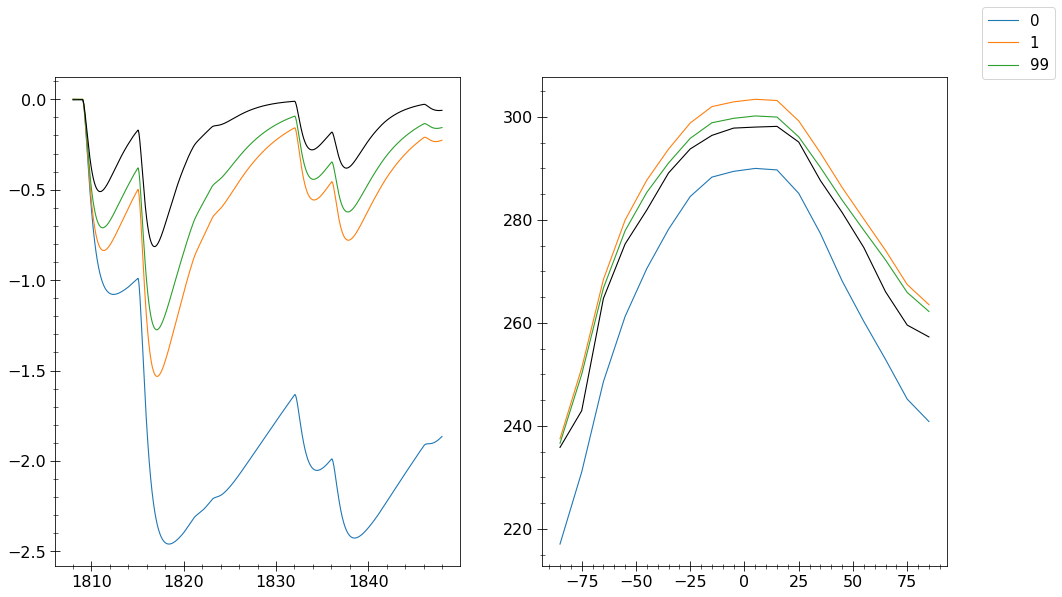

In [10]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
for i in [0,1,99]:
    ax[0].plot(Year_volc_1808_1858,data[1][i,0],label=i)
for i in [0,1,99]:
    ax[1].plot(Vars.Lat,data[0][i,0]+elevation)
#plt.plot(Year_volc_1808_1858,data[1,1])
#plt.plot(Year_volc_1808_1858,data[1,2])
#plt.plot(Year_volc_1808_1858,data[1,3])
#plt.plot(Year_volc_1808_1858,data[1,4])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')
ax[1].plot(Lat_10,ZMT_10,c='k')
plt.figlegend(fontsize=15)
#plt.xlim(1808,1858)
print(gamma)

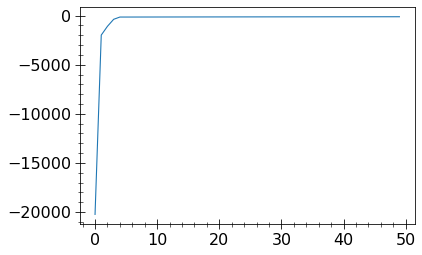

In [13]:
plt.plot(np.arange(50),dF[:,0])

In [31]:
print(gamma)
print(F)
print(dF)
print(P)

[1.00000000e-07 9.99972776e-08 7.96411807e-05 1.25390005e-04
 1.12720129e-04 1.10334142e-04 1.14971662e-04 1.10323682e-03]
[[4908.46279504 4907.68081928 4909.23973105 4895.28385247 4923.48298139
  4823.27040287 5054.43158254 4908.28522758 4908.63776618 4908.43195343
  4908.4941851  4907.80603045 4909.1303077 ]
 [1753.97298698 1753.97300141 1753.97298094 1754.48947943 1753.45663279
  1753.97427467 1753.97169816 1753.9730001  1753.97298007 1753.97303131
  1753.97294266 1753.97350971 1753.97247316]
 [1751.16403766 1751.16404821 1751.16402823 1751.67986844 1750.64831832
  1751.16532353 1751.16274737 1751.16404375 1751.16403319 1751.16407915
  1751.1639929  1751.16454727 1751.16352985]
 [ 276.06893623  276.0685077   276.0693672   276.25742215  275.88053744
   276.07116675  276.06670406  276.07005415  276.06781831  276.06927555
   276.0685969   276.07429964  276.06357283]
 [  90.3567686    90.35446318   90.35907689   90.33866833   90.37496561
    90.35391603   90.35962299   90.35721128   90.

In [18]:
print(70*4.2e6)

294000000.0


In [30]:
print(0.33*np.sum(((data[0][8,0]-target['ZMT'])*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2))
print(0.66*np.sum(((data[1][8,0]-target['GMT']))**2))

38.13576100244077
45.9309035943473


In [35]:
print(np.sqrt(np.dot(dF[-2],dF[-2])))
print(np.sqrt(np.dot(dF[0],dF[0])))

117.79102151319456
7220029.930903146


In [35]:
#setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P=[3.02794273e+08, 4.80868504e-01, 2.47299528e-15, 1.16506701e+00,
 1.16500290e+00, 1.16499030e+00]
#P1=[2.10056979e+08, 5.00042362e-01, 2.01124229e-15, 1.16500050e+00,1.16500009e+00, 1.16500191e+00]
config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config_CTRL=add_parameters(config_CTRL,P,labels)
data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['funccomp'],progressbar=True)
ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers.ini')
variable_importer(config_base,initialZMT=False)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config=add_parameters(config_base,P,labels)
Vars.T,Vars.T_global=ZMT,GMT   
data1=rk4alg(model_equation,config['eqparam'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


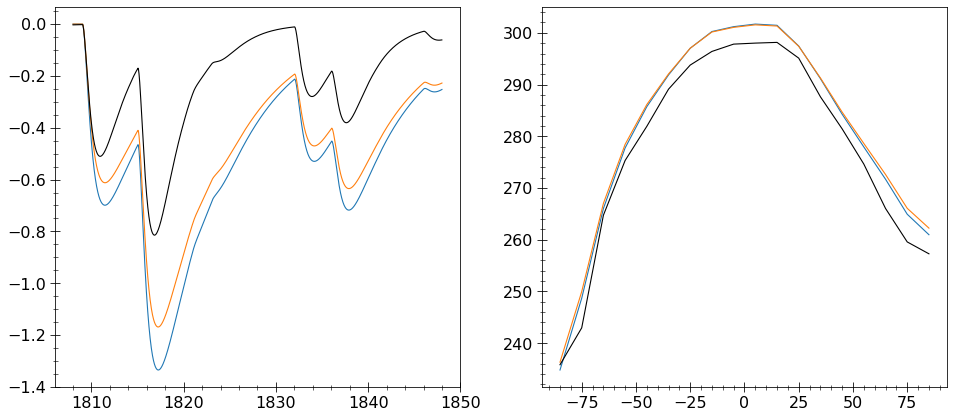

In [36]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
ax[0].plot(data[0]/constants.time_sec_year,data[2]-data[2][0])
ax[0].plot(data1[0]/constants.time_sec_year,data1[2]-data1[2][0])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')

elevation=-0.0065*np.array(ParasCTRL[1][1])
ax[1].plot(Vars.Lat,data[1][0]+elevation)
ax[1].plot(Vars.Lat,data1[1][0]+elevation)
ax[1].plot(Lat_10,ZMT_10,c='k')

plt.savefig('Coupled_Optimization.eps',format='EPS')

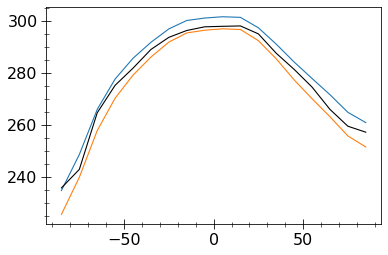

In [25]:
elevation=-0.0065*np.array(ParasCTRL[1][1])
plt.plot(Vars.Lat,data[1][0]+elevation)
plt.plot(Vars.Lat,data1[1][0]+elevation)
plt.plot(Lat_10,ZMT_10,c='k')